# Meroria a Corto Plazo LSTM Forecast

In [1]:
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
import sqlalchemy as db

In [2]:
tabla='2828hk'
conn = mysql.connector.connect(user='root', password='', host='localhost', database='stock_exchange')
stock = pd.DataFrame(pd.read_sql("SELECT * FROM "+tabla, conn))
conn.close()
stock.head(5)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,index,Date,Open,High,Low,Close,Volume
0,0,2019-01-02,102.800003,102.800003,99.250000,99.500000,12118897
1,1,2019-01-03,99.949997,100.400002,98.849998,99.599998,3562140
2,2,2019-01-04,99.000000,101.699997,99.000000,101.300003,2854212
3,3,2019-01-07,102.400002,103.300003,102.000000,102.300003,3527707
4,4,2019-01-08,102.699997,103.199997,102.000000,102.400002,4159683


### Estandarización

In [3]:
stock['Date']=pd.to_datetime(stock['Date'], format='%Y/%m/%d')
stock=stock.drop(['index'], axis=1)
stock=stock.set_index('Date')
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1038 entries, 2019-01-02 to 2023-03-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1038 non-null   float64
 1   High    1038 non-null   float64
 2   Low     1038 non-null   float64
 3   Close   1038 non-null   float64
 4   Volume  1038 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 48.7 KB


In [4]:
stock2=stock.asfreq(freq ='D', method='ffill')
stock2=stock2.sort_index()
stock2.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,102.800003,102.800003,99.250000,99.500000,12118897
2019-01-03,99.949997,100.400002,98.849998,99.599998,3562140
2019-01-04,99.000000,101.699997,99.000000,101.300003,2854212
2019-01-05,99.000000,101.699997,99.000000,101.300003,2854212
2019-01-06,99.000000,101.699997,99.000000,101.300003,2854212


In [5]:
opens=stock2.drop(['High', 'Low', 'Close', 'Volume'], axis=1)

train_data = opens[:len(opens)-365]
test_data = opens[len(opens)-365:]
test=test_data.copy()
train_data.shape, test_data.shape

((1171, 1), (365, 1))

In [6]:
opens

,Open
Date,
2019-01-02,102.800003
2019-01-03,99.949997
2019-01-04,99.000000
2019-01-05,99.000000
2019-01-06,99.000000
...,...
2023-03-13,65.500000
2023-03-14,66.000000
2023-03-15,66.019997


In [7]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)

scaled_test_data = scaler.transform(test)

In [28]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 365
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(12, activation='relu'))
lstm_model.add(Dense(8, activation='relu'))
lstm_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               40800     
                                                                 
 dense_7 (Dense)             (None, 12)                1212      
                                                                 
 dense_8 (Dense)             (None, 8)                 104       
                                                                 
Total params: 42,116
Trainable params: 42,116
Non-trainable params: 0
_________________________________________________________________


In [30]:
lstm_model.fit_generator(generator,epochs=100)

Epoch 1/100


C:\Users\rodrigo.gomez\AppData\Local\Temp\ipykernel_13584\4055281838.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



806/806 [==============================] - 94s 114ms/step - loss: 10909530456064.0000 - accuracy: 0.0000e+00
Epoch 2/100
806/806 [==============================] - 92s 114ms/step - loss: 0.2041 - accuracy: 0.0000e+00
Epoch 3/100
806/806 [==============================] - 87s 108ms/step - loss: 0.2035 - accuracy: 0.0000e+00
Epoch 4/100
806/806 [==============================] - 85s 106ms/step - loss: 0.2034 - accuracy: 0.0000e+00
Epoch 5/100
806/806 [==============================] - 85s 105ms/step - loss: 0.2033 - accuracy: 0.0000e+00
Epoch 6/100
806/806 [==============================] - 85s 105ms/step - loss: 0.2033 - accuracy: 0.0000e+00
Epoch 7/100
806/806 [==============================] - 85s 105ms/step - loss: 0.2032 - accuracy: 0.0000e+00
Epoch 8/100
806/806 [==============================] - 84s 104ms/step - loss: 0.2032 - accuracy: 0.0000e+00
Epoch 9/100
806/806 [==============================] - 86s 106ms/step - loss: 0.2032 - accuracy: 0.0000e+00
Epoch 10/100
806/806 [=====

KeyboardInterrupt: 

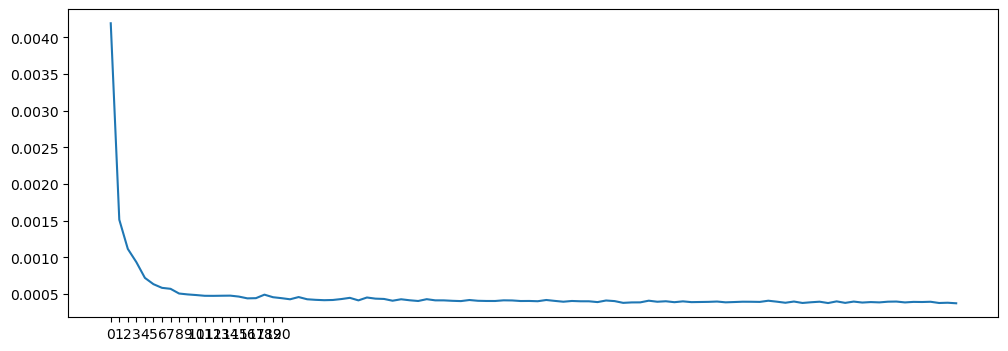

In [15]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [16]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [17]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [18]:
test_data['LSTM_Predictions'] = lstm_predictions

C:\Users\rodrigo.gomez\AppData\Local\Temp\ipykernel_13584\2583085160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['LSTM_Predictions'] = lstm_predictions


In [19]:
test_data

,Open,LSTM_Predictions
Date,,
2022-03-18,73.599998,70.958849
2022-03-19,73.599998,70.682636
2022-03-20,73.599998,70.104572
2022-03-21,76.000000,69.533764
2022-03-22,73.900002,68.976582
...,...,...
2023-03-13,65.500000,66.524101
2023-03-14,66.000000,66.524101
2023-03-15,66.019997,66.524101


In [21]:
import plotly.express as px
ai=test_data[["Open","LSTM_Predictions"]]
fig = px.line(ai, x=test_data.index, y=ai.columns,title="Predicción con Modelo LSTM", template = "plotly_dark")
fig.show()

### Otro tipo de LSTM

In [42]:
model=Sequential()
model.add(LSTM(40, input_shape=(None,1), activation='relu'))
model.add(Dropout(0.09))
model.add(Dense(1))

In [43]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])

In [44]:
modelo=model.fit(train_data, validation_data=(test_data), epochs=200, batch_size=30, verbose=1)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().